# 0. 프로젝트 정의하기!

# 1. 데이터 확인하기!

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
from os.path import join

from tqdm import tqdm #진행률바
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bisect

from sklearn.preprocessing import  LabelEncoder #문자를 숫자로 인코딩
from sklearn.model_selection import TimeSeriesSplit #변수n을 입력, n번의 반복으로 교차검즘을 할 것인지 정하는 것

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge #선형 모델
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

In [5]:
# 로컬
# data_dir = os.getenv('USERPROFILE') + '\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Project\Datathon\data'
data_dir = 'data'


In [6]:
train_path = join(data_dir, 'train.csv')
test_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_path, index_col=0).reset_index(drop=True)
test_X = pd.read_csv(test_path, index_col=0).reset_index(drop=True)

print(train.shape, test_X.shape)

(1216553, 13) (5463, 12)


In [7]:
train_copy = train.copy()

## 표본 추출을 통해 train 데이터의 수를 줄이겠습니다.
train = train.sample(n=123456, random_state=9)
train.shape

(123456, 13)

In [8]:
train.head()

,apartment_id,city,gu,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
233536,5959,서울특별시,노원구,상계동,720,상계주공6(고층),상계동 720 상계주공6(고층),58.01,1988,201605,11~20,9,30000
309676,4399,서울특별시,강서구,신정동,326,목동신시가지12,신정동 326 목동신시가지12,71.64,1988,200908,21~31,9,59800
799304,1334,부산광역시,북구,구포동,1103-2,구포현대,구포동 1103-2 구포현대,61.20,1994,200803,1~10,3,8200
834293,8752,부산광역시,북구,화명동,1426-1,우신,화명동 1426-1 우신,57.26,1987,201503,11~20,5,16100
656397,6914,부산광역시,서구,암남동,81-12,송도자유비치,암남동 81-12 송도자유비치,59.79,1997,201202,11~20,11,10000


In [9]:
test_X.head()

,apartment_id,city,gu,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,10453,서울특별시,강서구,목동,938,청학,목동 938 청학,35.5500,2002,201711,11~20,2
1,989,부산광역시,동구,초량동,1143-8,고관맨션,초량동 1143-8 고관맨션,68.7200,1977,201708,21~31,2
2,8597,부산광역시,사하구,괴정동,447-13,우림그린,괴정동 447-13 우림그린,72.5400,1989,201710,11~20,2
3,11086,서울특별시,강남구,대치동,1007-2,풍림아이원4차(1007-2),대치동 1007-2 풍림아이원4차(1007-2),111.5400,2004,201707,1~10,10
4,2121,부산광역시,사하구,다대동,1670,다대롯데캐슬블루,다대동 1670 다대롯데캐슬블루,119.6398,2014,201712,11~20,21


데이터 정보

0. apartment_id: 아파트 아이디
1. city: 도시
2. dong: 동
3. jibun: 지번
4. apt: 아파트단지 이름
5. addr_kr: 주소
6. exclusive_use_area: 전용면적
7. year_of_completion: 설립일자
8. transaction_year_month: 거래년월
9. transaction_date: 거래날짜
10. floor: 층
11. transaction_real_price: 실거래가(train 만 존재)

<AxesSubplot:>

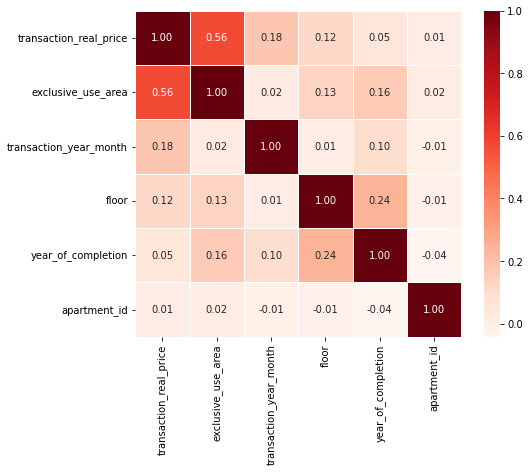

In [10]:
#상관관계 확인
k = train.shape[1] #히트맵 변수 갯수
corr_mat = train.corr() #변수간의 상관관계
cols = corr_mat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

# 2. train, test 데이터 합치기!

In [11]:
train_y = train['transaction_real_price']
print(train_y.head())

print(train.shape)
train_X = train.drop('transaction_real_price', axis=1)
print(train_X.shape)

233536    30000
309676    59800
799304     8200
834293    16100
656397    10000
Name: transaction_real_price, dtype: int64
(123456, 13)
(123456, 12)


In [12]:
whole_X = pd.concat((train_X, test_X), axis=0)
whole_X.shape

(128919, 12)

In [13]:
whole_X.head()

,apartment_id,city,gu,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
233536,5959,서울특별시,노원구,상계동,720,상계주공6(고층),상계동 720 상계주공6(고층),58.01,1988,201605,11~20,9
309676,4399,서울특별시,강서구,신정동,326,목동신시가지12,신정동 326 목동신시가지12,71.64,1988,200908,21~31,9
799304,1334,부산광역시,북구,구포동,1103-2,구포현대,구포동 1103-2 구포현대,61.20,1994,200803,1~10,3
834293,8752,부산광역시,북구,화명동,1426-1,우신,화명동 1426-1 우신,57.26,1987,201503,11~20,5
656397,6914,부산광역시,서구,암남동,81-12,송도자유비치,암남동 81-12 송도자유비치,59.79,1997,201202,11~20,11


In [14]:
whole_X.describe()

,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,128919.000000,128919.000000,128919.000000,128919.000000,128919.000000
mean,6302.792063,78.257199,1998.405797,201316.686850,9.291927
std,3573.166050,29.468481,9.009649,296.146901,6.564141
min,2.000000,10.321500,1961.000000,200801.000000,-2.000000
25%,3351.000000,59.760000,1993.000000,201011.000000,4.000000
50%,5962.000000,82.301900,1999.000000,201403.000000,8.000000
75%,9429.000000,84.970000,2005.000000,201603.000000,13.000000
max,12658.000000,273.860000,2017.000000,201712.000000,80.000000


In [15]:
whole_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128919 entries, 233536 to 5462
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   apartment_id            128919 non-null  int64  
 1   city                    128919 non-null  object 
 2   gu                      128919 non-null  object 
 3   dong                    128919 non-null  object 
 4   jibun                   128919 non-null  object 
 5   apt                     128919 non-null  object 
 6   addr_kr                 128919 non-null  object 
 7   exclusive_use_area      128919 non-null  float64
 8   year_of_completion      128919 non-null  int64  
 9   transaction_year_month  128919 non-null  int64  
 10  transaction_date        128919 non-null  object 
 11  floor                   128919 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 12.8+ MB


# 3. 탐색적 자료 분석하기!

In [16]:
print(whole_X.shape)
whole_X = whole_X.drop(['jibun', 'apt', 'addr_kr', 'transaction_date'], axis=1)
print(whole_X.shape)

(128919, 12)
(128919, 8)


In [17]:
whole_X.head()

,apartment_id,city,gu,dong,exclusive_use_area,year_of_completion,transaction_year_month,floor
233536,5959,서울특별시,노원구,상계동,58.01,1988,201605,9
309676,4399,서울특별시,강서구,신정동,71.64,1988,200908,9
799304,1334,부산광역시,북구,구포동,61.20,1994,200803,3
834293,8752,부산광역시,북구,화명동,57.26,1987,201503,5
656397,6914,부산광역시,서구,암남동,59.79,1997,201202,11


In [18]:
print(whole_X.shape)
whole_X = whole_X.drop(['year_of_completion', 'transaction_year_month'], axis=1)
print(whole_X.shape)

(128919, 8)
(128919, 6)


In [19]:
train_dong = train_copy[['dong', 'transaction_real_price']].groupby('dong').mean().sort_values('transaction_real_price').reset_index()
train_dong.head()

,dong,transaction_real_price
0,신선동3가,5500.000000
1,장안읍 명례리,5508.333333
2,신창동2가,5531.250000
3,봉래동5가,5732.546012
4,중앙동4가,6312.500000


In [20]:
dong_num = {}
for i in range(len(train_dong)):
    dong = train_dong['dong'][i]
    dong_num[dong] = i

In [21]:
whole_X = whole_X.replace({'dong': dong_num})
whole_X.head()

,apartment_id,city,gu,dong,exclusive_use_area,floor
233536,5959,서울특별시,노원구,162,58.01,9
309676,4399,서울특별시,강서구,358,71.64,9
799304,1334,부산광역시,북구,63,61.20,3
834293,8752,부산광역시,북구,137,57.26,5
656397,6914,부산광역시,서구,91,59.79,11


In [22]:
train_gu = train_copy[['gu', 'transaction_real_price']].groupby('gu').mean().sort_values('transaction_real_price').reset_index()
train_gu.head()

,gu,transaction_real_price
0,영도구,14159.843340
1,사하구,15141.810976
2,북구,16824.416253
3,동구,18717.596677
4,진구,18753.698471


In [23]:
gu_num = {}
for i in range(len(train_gu)):
    gu = train_gu['gu'][i]
    gu_num[gu] = i

In [24]:
whole_X = whole_X.replace({'gu': gu_num})
whole_X.head()

,apartment_id,city,gu,dong,exclusive_use_area,floor
233536,5959,서울특별시,14,162,58.01,9
309676,4399,서울특별시,22,358,71.64,9
799304,1334,부산광역시,2,63,61.20,3
834293,8752,부산광역시,2,137,57.26,5
656397,6914,부산광역시,5,91,59.79,11


In [25]:
train_city = train_copy[['city', 'transaction_real_price']].groupby('city').mean().sort_values('transaction_real_price').reset_index()
train_city.head()

,city,transaction_real_price
0,부산광역시,21102.045856
1,서울특별시,49169.779317


In [26]:
city_num = {}
for i in range(len(train_city)):
    city = train_city['city'][i]
    city_num[city] = i
    
city_num

{'부산광역시': 0, '서울특별시': 1}

In [27]:
whole_X = whole_X.replace({'city': city_num})
whole_X.head()

,apartment_id,city,gu,dong,exclusive_use_area,floor
233536,5959,1,14,162,58.01,9
309676,4399,1,22,358,71.64,9
799304,1334,0,2,63,61.20,3
834293,8752,0,2,137,57.26,5
656397,6914,0,5,91,59.79,11


<AxesSubplot:xlabel='floor', ylabel='transaction_real_price'>

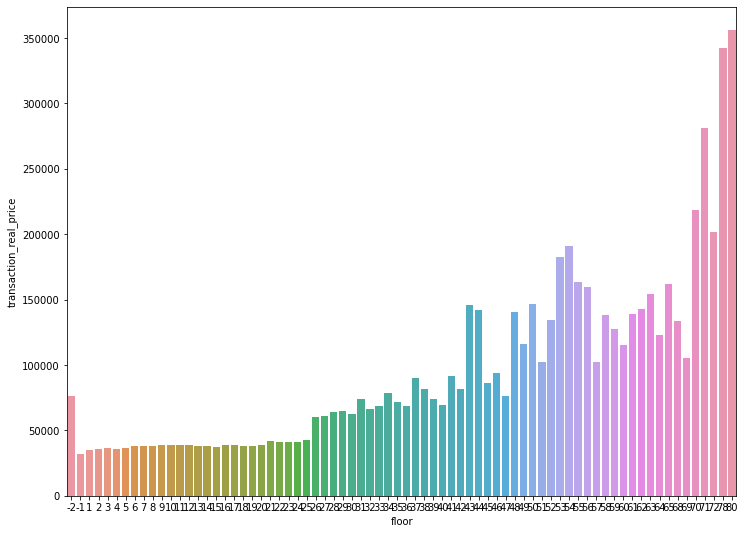

In [28]:
f, ax = plt.subplots(figsize=(12, 9))
group = train.groupby(['floor']).mean()['transaction_real_price']
sns.barplot(group.index, group)

In [29]:
whole_X['floor'].describe()

count    128919.000000
mean          9.291927
std           6.564141
min          -2.000000
25%           4.000000
50%           8.000000
75%          13.000000
max          80.000000
Name: floor, dtype: float64

In [30]:
whole_X['floor_group'] = pd.cut(whole_X['floor'], bins=[-5, 25, 49, 61, 75, 80], labels=[0, 1, 2, 3, 4]).astype(int)
whole_X['floor_group'].head()

233536    0
309676    0
799304    0
834293    0
656397    0
Name: floor_group, dtype: int64

In [31]:
print(whole_X.shape)
whole_X = whole_X.drop('floor', axis=1)
print(whole_X.shape)

(128919, 7)
(128919, 6)


In [32]:
train_apartment_id = train_copy[['apartment_id', 'transaction_real_price']].groupby('apartment_id').mean().sort_values('transaction_real_price').reset_index()
train_apartment_id.head()

,apartment_id,transaction_real_price
0,7165,1428.263889
1,9788,1852.413793
2,7406,1853.189189
3,9789,1855.584416
4,12076,2000.000000


In [33]:
apartment_id_num = {}
for i in range(len(train_apartment_id)):
    apartment_id = train_apartment_id['apartment_id'][i]
    apartment_id_num[apartment_id] = i

In [34]:
apartment_id_num

{7165: 0,
 9788: 1,
 7406: 2,
 9789: 3,
 12076: 4,
 7058: 5,
 7057: 6,
 7072: 7,
 7059: 8,
 7056: 9,
 156: 10,
 1351: 11,
 6936: 12,
 2452: 13,
 9723: 14,
 5117: 15,
 1324: 16,
 4534: 17,
 23: 18,
 6930: 19,
 10429: 20,
 10427: 21,
 6466: 22,
 8022: 23,
 6512: 24,
 9741: 25,
 8285: 26,
 659: 27,
 10877: 28,
 8287: 29,
 4166: 30,
 6511: 31,
 3023: 32,
 8098: 33,
 6673: 34,
 5106: 35,
 2000: 36,
 8286: 37,
 4646: 38,
 11652: 39,
 11338: 40,
 2346: 41,
 10620: 42,
 1514: 43,
 5048: 44,
 6577: 45,
 8029: 46,
 5118: 47,
 10495: 48,
 10496: 49,
 9912: 50,
 7151: 51,
 6931: 52,
 5211: 53,
 7047: 54,
 11421: 55,
 11794: 56,
 10515: 57,
 8277: 58,
 9914: 59,
 9162: 60,
 7030: 61,
 7152: 62,
 11208: 63,
 7031: 64,
 7162: 65,
 9067: 66,
 2305: 67,
 11216: 68,
 1996: 69,
 8074: 70,
 11123: 71,
 4536: 72,
 10424: 73,
 919: 74,
 1611: 75,
 283: 76,
 336: 77,
 1711: 78,
 12262: 79,
 6659: 80,
 3274: 81,
 1903: 82,
 11147: 83,
 3544: 84,
 9469: 85,
 5678: 86,
 10422: 87,
 7404: 88,
 364: 89,
 6155: 90

In [35]:
whole_X

,apartment_id,city,gu,dong,exclusive_use_area,floor_group
233536,5959,1,14,162,58.010,0
309676,4399,1,22,358,71.640,0
799304,1334,0,2,63,61.200,0
834293,8752,0,2,137,57.260,0
656397,6914,0,5,91,59.790,0
...,...,...,...,...,...,...
5458,8965,1,30,376,84.050,0
5459,3831,1,30,467,84.930,0
5460,5550,1,16,202,110.188,0
5461,3371,1,19,252,92.440,0


In [36]:
whole_X = whole_X.replace({'apartment_id': apartment_id_num})
whole_X.head()

,apartment_id,city,gu,dong,exclusive_use_area,floor_group
233536,6096,1,14,162,58.01,0
309676,10570,1,22,358,71.64,0
799304,2746,0,2,63,61.20,0
834293,1537,0,2,137,57.26,0
656397,812,0,5,91,59.79,0


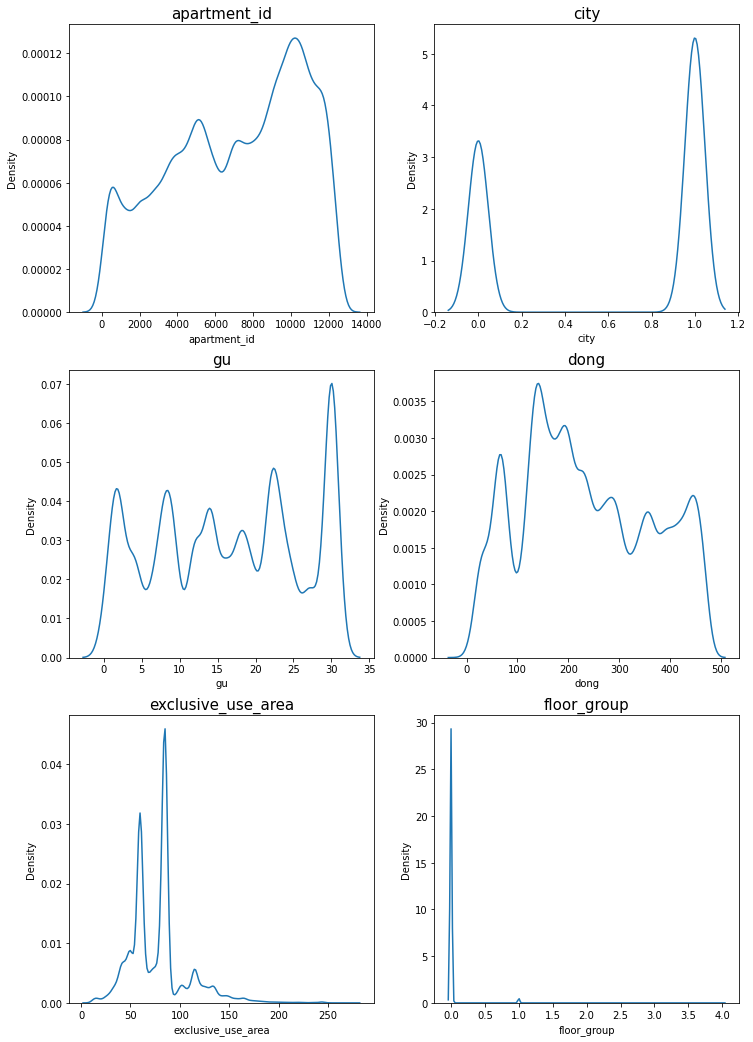

In [37]:
fig, ax = plt.subplots(3, 2, figsize=(12, 18))

columns = whole_X.columns
count = 0
for row in range(3):
    for col in range(2):
        sns.kdeplot(data=whole_X[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == whole_X.shape[1]:
            break
            
plt.show()

In [38]:
train_y.values

array([30000, 59800,  8200, ..., 38000, 22000, 31000])

In [39]:
train_temp = whole_X.iloc[:len(train), :]

train_temp.loc[:, 'transaction_real_price'] = train_y.values
train_temp.head()

,apartment_id,city,gu,dong,exclusive_use_area,floor_group,transaction_real_price
233536,6096,1,14,162,58.01,0,30000
309676,10570,1,22,358,71.64,0,59800
799304,2746,0,2,63,61.20,0,8200
834293,1537,0,2,137,57.26,0,16100
656397,812,0,5,91,59.79,0,10000


<AxesSubplot:>

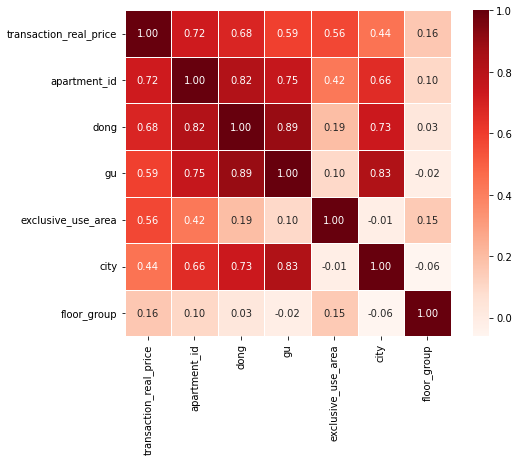

In [40]:
#상관관계 확인
k = train_temp.shape[1] #히트맵 변수 갯수
corr_mat = train_temp.corr() #변수간의 상관관계
cols = corr_mat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(train_temp[cols].values.T)

f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

In [41]:
whole_X

,apartment_id,city,gu,dong,exclusive_use_area,floor_group
233536,6096,1,14,162,58.010,0
309676,10570,1,22,358,71.640,0
799304,2746,0,2,63,61.200,0
834293,1537,0,2,137,57.260,0
656397,812,0,5,91,59.790,0
...,...,...,...,...,...,...
5458,9875,1,30,376,84.050,0
5459,12430,1,30,467,84.930,0
5460,9881,1,16,202,110.188,0
5461,7387,1,19,252,92.440,0


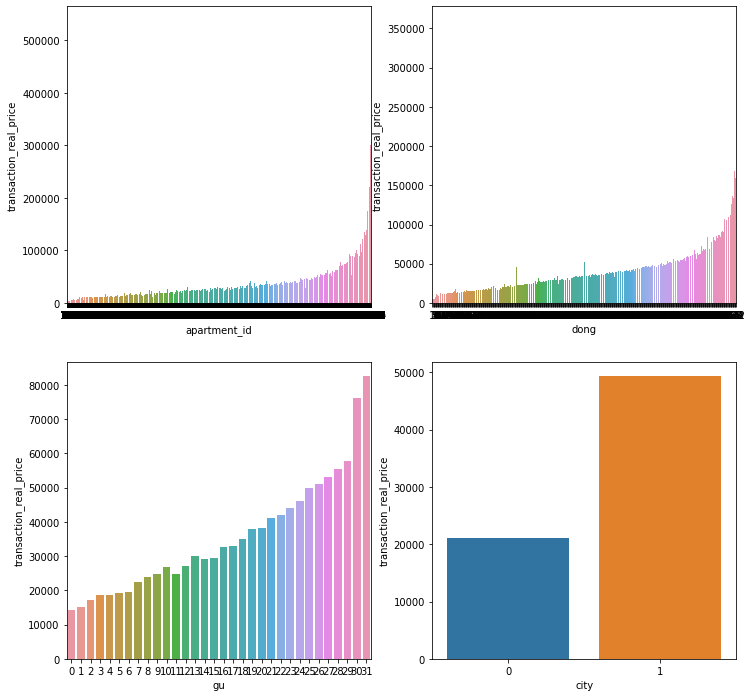

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

cols = ['apartment_id', 'dong', 'gu', 'city']
count = 0
for col in cols:
    sns.barplot(x=whole_X.iloc[:len(train_X)][col], y=train_y, ax=ax[count // 2][count % 2], ci=None)
    count += 1
    if count == len(cols):
        break
            
plt.show()

In [43]:
skew_columns = ['apartment_id', 'exclusive_use_area']

for column in skew_columns:
    whole_X[column] = np.log1p(whole_X[column].values)

<AxesSubplot:xlabel='apartment_id', ylabel='Count'>

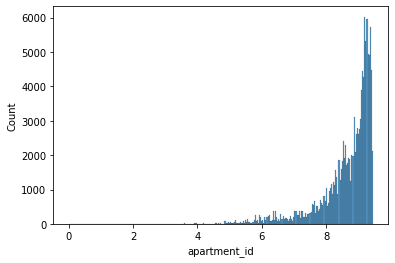

In [44]:
sns.histplot(whole_X['apartment_id'])

<AxesSubplot:xlabel='exclusive_use_area', ylabel='Count'>

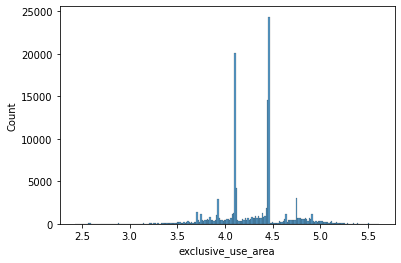

In [45]:
sns.histplot(whole_X['exclusive_use_area'])

In [46]:
whole_X.columns

Index(['apartment_id', 'city', 'gu', 'dong', 'exclusive_use_area',
       'floor_group'],
      dtype='object')

In [47]:
whole_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128919 entries, 233536 to 5462
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   apartment_id        128919 non-null  float64
 1   city                128919 non-null  int64  
 2   gu                  128919 non-null  int64  
 3   dong                128919 non-null  int64  
 4   exclusive_use_area  128919 non-null  float64
 5   floor_group         128919 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 6.9 MB


In [48]:
whole_X_onehot = pd.get_dummies(whole_X, columns=['city', 'gu', 'dong', 'floor_group'])

In [49]:
train_y.describe()

count    123456.000000
mean      38349.689647
std       31291.171204
min         100.000000
25%       19000.000000
50%       31000.000000
75%       47200.000000
max      650000.000000
Name: transaction_real_price, dtype: float64

train_y -> Skewness: 3.427127, Kurtosis: 23.742378


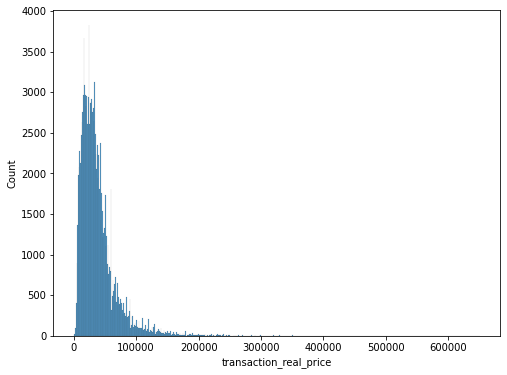

In [50]:
f, ax = plt.subplots(figsize = (8,6))
sns.histplot(train_y)
print("%s -> Skewness: %f, Kurtosis: %f" %  ('train_y', train_y.skew(), train_y.kurt()))

In [51]:
train_y = np.log1p(train_y)
print("%s -> Skewness: %f, Kurtosis: %f" %  ('train_y', train_y.skew(), train_y.kurt()))

train_y -> Skewness: -0.090495, Kurtosis: 0.269657


<AxesSubplot:xlabel='transaction_real_price', ylabel='Count'>

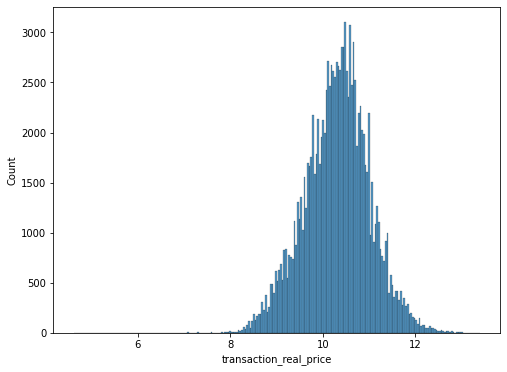

In [52]:
f, ax = plt.subplots(figsize = (8,6))
sns.histplot(train_y)

In [53]:
train_X = whole_X_onehot.iloc[:len(train), :]
test_X = whole_X_onehot.iloc[len(train):, :]

print(train_X.shape)
print(test_X.shape)

(123456, 493)
(5463, 493)


In [54]:
train_X.head()

,apartment_id,exclusive_use_area,city_0,city_1,gu_0,gu_1,gu_2,gu_3,gu_4,gu_5,...,dong_468,dong_469,dong_470,dong_471,dong_472,floor_group_0,floor_group_1,floor_group_2,floor_group_3,floor_group_4
233536,8.715552,4.077707,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
309676,9.265870,4.285516,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
799304,7.918265,4.130355,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
834293,7.338238,4.064916,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
656397,6.700731,4.107425,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [55]:
def my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=7):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train_X, train_y)

    # 퍙기 결과 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 평가 결과를 담을 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-results['score'])
    results = results.sort_values('RMSLE')

    return results

In [56]:
random_state = 9

In [57]:
# n_estimators, max_depth, min_child_samples, num_leaves, boosting

In [58]:
model = LGBMRegressor(random_state=random_state)

param_grid = {
    'n_estimators': [2400], # 2500
    'max_depth': [20], # 19
    'num_leaves': [34], # 35
    'min_child_samples': [16], # 18
}
my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=7)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,max_depth,min_child_samples,n_estimators,num_leaves,score,RMSLE
0,20,16,2400,34,-0.034767,0.18646


In [59]:
def tsize(train_X): # 지극히 주관적인 적당한 test size 값 찾는 함수
    length = len(train_X)
    return round(0.14 * (1 + length / 10 ** 4) ** (10 ** 4 / length) - 0.13, 2)

In [60]:
def rmse(y_test, y_pred): # RMSE 손실 함수
    # 로그를 씌웠던 레이블에 다시 지수를 씌워서 스케일을 원상복구하고 평가하기
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [61]:
def get_scores(models, train_X, train_y):
    scores = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, random_state=random_state, test_size=tsize(train_X))
        
        scaler = RobustScaler() # 표준화 스케일러
        X_train = scaler.fit_transform(X_train) # X_train 데이터를 fit과 동시에 transform
        X_test = scaler.transform(X_test) # X_test 데이터를 transform
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        scores[model_name] = rmse(y_test, y_pred) # 모델 별 RMSE 값 계산
        scores_df = pd.DataFrame(scores, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return scores_df

In [62]:
print(train_X.shape, train_y.shape, test_X.shape)

(123456, 493) (123456,) (5463, 493)


In [84]:
def save_submission(last_model, train_X, train_y, test_X, n):
    model_name = last_model.__class__.__name__
    last_model.fit(train_X, train_y)
    test_y = last_model.predict(test_X)
    test_y = np.expm1(test_y) # 스케일 원상복구
    data_dir = 'data'
    submission_path = join(data_dir, 'submission.csv')
    submission = pd.read_csv(submission_path)
    submission['transaction_real_price'] = test_y

    submission_csv_path = '{}/submission_{}.csv'.format(data_dir, n)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [85]:
last_model = LGBMRegressor(max_depth=20, n_estimators=2400, min_child_samples=16, num_leaves=34)

In [86]:
save_submission(last_model, train_X, train_y, test_X, 1)

data/submission_1.csv saved!
